In [1]:
from IPython.display import clear_output

In [2]:
!apt-get install gcc-4.8 gcc-5 g++-4.8 g++-5
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install gfortran-4.8
!apt-get install gfortran-5
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev
clear_output()

In [3]:
!pip install torch==1.3.0 rtree trimesh
clear_output()

In [4]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-4.8 10
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-5 20
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-4.8 10
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-5 20
clear_output()

In [5]:
%cd /content

/content


In [6]:
!git clone https://github.com/mszarski/diffsim.git

Cloning into 'diffsim'...
remote: Enumerating objects: 1209, done.
remote: Counting objects: 100% (1209/1209), done.
remote: Compressing objects: 100% (786/786), done.
remote: Total 1209 (delta 427), reused 1056 (delta 301), pack-reused 0
Receiving objects: 100% (1209/1209), 27.80 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (427/427), done.


In [7]:
!chmod +x diffsim/arcsim/dependencies/taucs/configure

In [8]:
%cd /content

/content


In [9]:
%cd diffsim
!update-alternatives --set gcc "/usr/bin/gcc-4.8"
!update-alternatives --set g++ "/usr/bin/g++-4.8"
%cd arcsim/dependencies/
!make 
%cd ../..
!update-alternatives --set gcc "/usr/bin/gcc-5"
!update-alternatives --set g++ "/usr/bin/g++-5"
!make -j 8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

clear_output()

In [ ]:
##restart runtime here

In [1]:
%cd /content/diffsim/pysim

/content/diffsim/pysim


In [2]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [3]:
inital_fabric_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_flatmesh_simplified_2.obj"
tool_mesh_path = "/content/drive/My Drive/draping_workspace/apb_mm_simplified_2.obj"
handles = [92,31, 118,67]


boundary = [ 16,  62,  98, 100,  14, 117,  31,  85,  55,  68, 108,   5,  45,
         74,  83, 127,  67,  84,  33, 132, 111, 118,   9,  93, 123,  44,
         58,  43, 113,   3,  22,  92,  79,  87,  78, 130]


fabric_t = [-0.1,-0.3,0.0]
tool_t = [-0.1,-0.3,-0.5]
scale = 0.01
seed_pt_idx = 61 #middle
# seed_pt_idx = 132 #short end
# seed_pt_idx = 62 #long end


In [4]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load(tool_mesh_path,process=False)
flat_mesh = trimesh.load(inital_fabric_mesh_path,process=False)
scene = trimesh.Scene(base_frame='world')

curved_mesh.apply_scale(scale)
flat_mesh.apply_scale(scale)

transform = tf.translation_matrix(fabric_t)
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)


transform = tf.translation_matrix(tool_t)
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

#scene.show()

In [5]:
import networkx as nx
import torch
import itertools

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)
torch_tool_v = torch.tensor(curved_mesh.vertices, dtype=torch.float64)
torch_tool_n = torch.tensor(curved_mesh.vertex_normals, dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def calculate_rings(seed_pt_idx, boundary):
    rings = []
    rings.append([seed_pt_idx])
    while True:
        next_ring = [list(G[i].keys()) for i in rings[-1]]
        next_ring_no_center = set(itertools.chain(*next_ring)) - set(itertools.chain(*rings))
        rings.append(list(next_ring_no_center))
        if set(boundary) <= set(itertools.chain(*rings)):
            return rings[1:]

rings = calculate_rings(seed_pt_idx, boundary)

def ring_contact_loss_normal(sim, rings,thresh = 5e-3):

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    #n_dists = torch.einsum('ij,ij->i', torch_fabric_v - torch_tool_v, torch_tool_n)

    n_dists = torch.stack(dists)
    pos_n_dists = torch.nn.functional.relu(n_dists)
    # weights = torch.exp(-pos_n_dists/thresh)

    ring_weights = np.linspace(10,0,len(rings))

    contact = torch.tensor(0.0)

    for i in range(len(rings)):
        contact += pos_n_dists[rings[i]].mean()*ring_weights[i]

    return contact

def total_contact_loss_dist_normal(sim, exclude_indices = None, thresh = 5e-3):

    if exclude_indices is None: 
        exclude_indices = []

    one_rings = [list(G[i].keys()) for i in exclude_indices]
    exclude_indices.append(list(itertools.chain(*one_rings)))

    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        if not i in exclude_indices:
            dists.append(torch.dot(sim.cloths[0].mesh.nodes[i].x - torch_tool_v[i],torch_tool_n[i]))

    n_dists = torch.stack(dists)

    pos_z_dists = torch.nn.functional.relu(n_dists)
    # contact_loss = torch.mean(torch.exp(-pos_z_dists/thresh))

    contact_loss = torch.mean(pos_z_dists)

    return contact_loss

In [7]:
#https://raw.githubusercontent.com/akanazawa/cmr/master/nnutils/laplacian.py

"""
Computes Lx and it's derivative, where L is the graph laplacian on the mesh with cotangent weights.

1. Given V, F, computes the cotangent matrix (for each face, computes the angles) in pytorch.
2. Then it's taken to NP and sparse L is constructed.

Mesh laplacian computation follows Alec Jacobson's gptoolbox.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
from torch.autograd import Variable

import numpy as np
from scipy import sparse

#############
### Utils ###
#############
def convert_as(src, trg):
    src = src.type_as(trg)
    if src.is_cuda:
        src = src.cuda(device=trg.get_device())
    return src

########################################################################
################# Wrapper class for a  PythonOp ########################
##### All functions must only use torch Tensors as inputs/outputs ######
########################################################################
class Laplacian(torch.autograd.Function):
    def __init__(self, faces):
        # Faces is B x F x 3, cuda torch Variabe.
        # Reuse faces.
        self.F_np = faces.data.cpu().numpy()
        self.F = faces.data
        self.L = None

    def forward(self, V):
        # If forward is explicitly called, V is still a Parameter or Variable
        # But if called through __call__ it's a tensor.
        # This assumes __call__ was used.
        #
        # Input:
        #   V: B x N x 3
        #   F: B x F x 3
        # Outputs: Lx B x N x 3
        #
        # Numpy also doesnt support sparse tensor, so stack along the batch

        V_np = V.cpu().detach().numpy()
        batchV = V_np.reshape(-1, 3)

        if self.L is None:
            # print('Computing the Laplacian!')
            # Compute cotangents
            C = cotangent(V, self.F)
            C_np = C.cpu().numpy()
            batchC = C_np.reshape(-1, 3)            
            # Adjust face indices to stack:
            offset = np.arange(0, V.size(0)).reshape(-1, 1, 1) * V.size(1)
            F_np = self.F_np + offset
            batchF = F_np.reshape(-1, 3)

            rows = batchF[:, [1, 2, 0]].reshape(-1)
            cols = batchF[:, [2, 0, 1]].reshape(-1)
            # Final size is BN x BN
            BN = batchV.shape[0]
            L = sparse.csr_matrix((batchC.reshape(-1), (rows, cols)), shape=(BN,BN))
            L = L + L.T
            # np.sum on sparse is type 'matrix', so convert to np.array
            M = sparse.diags(np.array(np.sum(L, 1)).reshape(-1), format='csr')
            L = L - M
            # remember this
            self.L = L
            # import matplotlib.pylab as plt
            # plt.ion()
            # plt.clf()
            # plt.spy(L)
            # plt.show()
            # import ipdb; ipdb.set_trace()

        Lx = self.L.dot(batchV).reshape(V_np.shape)

        return convert_as(torch.Tensor(Lx), V)

    def backward(self, grad_out):
        """
        Just L'g = Lg
        Args:
           grad_out: B x N x 3
        Returns:
           grad_vertices: B x N x 3
        """
        g_o = grad_out.cpu().numpy()
        # Stack
        g_o = g_o.reshape(-1, 3)
        Lg = self.L.dot(g_o).reshape(grad_out.shape)

        return convert_as(torch.Tensor(Lg), grad_out)


def cotangent(V, F):
    # Input:
    #   V: B x N x 3
    #   F: B x F  x3
    # Outputs:
    #   C: B x F x 3 list of cotangents corresponding
    #     angles for triangles, columns correspond to edges 23,31,12

    # B x F x 3 x 3
    indices_repeat = torch.stack([F, F, F], dim=2)

    v1 = torch.gather(V, 1, indices_repeat[:, :, :, 0])
    v2 = torch.gather(V, 1, indices_repeat[:, :, :, 1])
    v3 = torch.gather(V, 1, indices_repeat[:, :, :, 2])
    
    l1 = torch.sqrt(((v2 - v3)**2).sum(2))
    l2 = torch.sqrt(((v3 - v1)**2).sum(2))
    l3 = torch.sqrt(((v1 - v2)**2).sum(2))

    # semiperimieters
    sp = (l1 + l2 + l3) * 0.5

    # Heron's formula for area
    A = 2*torch.sqrt( sp * (sp-l1)*(sp-l2)*(sp-l3))

    cot23 = (l2**2 + l3**2 - l1**2)
    cot31 = (l1**2 + l3**2 - l2**2)
    cot12 = (l1**2 + l2**2 - l3**2)

    # 2 in batch
    C = torch.stack([cot23, cot31, cot12], 2) / torch.unsqueeze(A, 2) / 4

    return C

def laplacian_loss_fn(sim):

    lp = Laplacian(torch.tensor(curved_mesh.faces).unsqueeze(0))

    vs = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        vs.append(sim.cloths[0].mesh.nodes[i].x)

    vs = torch.stack(vs).unsqueeze(0)

    Lx = lp(vs)
    Lx = Lx.view(-1, Lx.size(2))
    loss = torch.norm(Lx, p=2, dim=1).mean()

    return loss

In [8]:
import arcsim
import json
import os

def run(phase_config):
  torch.manual_seed(0)
  np.random.seed(0)
  torch.set_num_threads(8)

  if not os.path.exists(phase_config['out_path']):
    os.mkdir(phase_config['out_path'])

  config = json.loads(phase_config['json_config'])

  with open(phase_config['out_path']+'/conf.json','w') as f:
    json.dump(config, f)

  sim=arcsim.get_sim()

  param_v = torch.zeros([phase_config['steps'], 4,3],dtype=torch.float64, requires_grad=True)

  optimizer = torch.optim.Adam([param_v],phase_config['lr'])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)

  best_loss = 1e30
  best_epoch = 0

  epoch = 0
  while True:

    if epoch < phase_config['epochs']:
      arcsim.init_physics(phase_config['out_path']+'/conf.json', phase_config['out_path']+'/out%d'%epoch,False)
    else:
      arcsim.init_physics(phase_config['out_path']+'/conf.json',phase_config['out_path']+'/out',False)

    optimizer.zero_grad()

    loss = phase_config['run_sim'](sim, param_v, phase_config['pre_steps'], phase_config['steps'])

    loss.backward(retain_graph=True)

    if loss.item() < best_loss:
      best_loss = loss.item()
      best_epoch = epoch
      torch.save(param_v, 'best_params.pt')
      print('new best')

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)

    scheduler.step(loss.item())

    if epoch>=phase_config['epochs']:
      break
    epoch = epoch + 1

  return torch.load('best_params.pt'), best_epoch


In [21]:
def phase1_sim(sim,param_v, pre_steps, steps):

  seed_pt_losses = []
  contact_losses = []
  step_seed_pt_contact_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_seed_pt_dist = torch.dot(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[seed_pt_idx],torch_tool_n[seed_pt_idx])
      n_dist = torch.nn.functional.relu(step_seed_pt_dist)
      thresh = 5e-3
      step_seed_pt_contact_loss = -torch.sum(torch.exp(-n_dist/thresh))
      step_seed_pt_contact_losses.append(step_seed_pt_contact_loss)

      step_seed_pt_loss = torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - sim.obstacles[0].curr_state_mesh.nodes[seed_pt_idx].x)
      seed_pt_losses.append(step_seed_pt_loss)

      step_contact_loss = -total_contact_loss_dist_normal(sim,[seed_pt_idx],5e-3)
      contact_losses.append(step_contact_loss)

    arcsim.sim_step()

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.sum(contact_loss_steps)

  step_seed_pt_contact_loss_steps = torch.stack(step_seed_pt_contact_losses,dim=0)
  seed_pt_contact_loss = -torch.logsumexp(-step_seed_pt_contact_loss_steps*1000,0)/1000
         
  seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  seed_pt_loss = torch.sum(seed_pt_loss_steps)

  print(f"contact loss: {contact_loss}, seed_pt_loss: {seed_pt_loss} seed_pt_contact_loss: {seed_pt_contact_loss}")

  total_loss = seed_pt_loss + seed_pt_contact_loss + contact_loss
  
  return total_loss


def phase2_sim(sim,param_v, pre_steps, steps):

  boundary_losses = []
  contact_losses = []
  laplacian_losses = []

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
  
      step_contact_loss = ring_contact_loss_normal(sim,rings)
      contact_losses.append(step_contact_loss)

      loss_idxs = [*handles]
      step_boundary_loss = torch.tensor(0.0)
      for i in loss_idxs:
        w = 1
        step_boundary_loss += w*torch.norm(sim.cloths[0].mesh.nodes[i].x - sim.obstacles[0].curr_state_mesh.nodes[i].x)

      boundary_losses.append(step_boundary_loss)
      laplacian_losses.append(laplacian_loss_fn(sim))

    arcsim.sim_step()

  laplacian_loss_steps = torch.stack(laplacian_losses,dim=0)
  laplacian_loss = torch.mean(laplacian_loss_steps)

  contact_loss_steps = torch.stack(contact_losses,dim=0)
  contact_loss = torch.mean(contact_loss_steps)
         
  boundary_loss_steps = torch.stack(boundary_losses,dim=0)
  boundary_loss = torch.mean(boundary_loss_steps)

  boundary_loss = boundary_loss*10

  contact_loss = contact_loss*1

  laplacian_loss = laplacian_loss * 10

  print(f"contact loss: {contact_loss}, boundary_loss: {boundary_loss}, laplacian_loss: {laplacian_loss}")

  total_loss = boundary_loss + contact_loss + laplacian_loss

  return total_loss

def phase3_sim(sim,param_v, pre_steps, steps):

  phase1 = torch.load('phase1.pt')
  phase2 = torch.load('phase2.pt')
  param_v = torch.cat([phase1,phase2],dim=0)

  positions = np.zeros((steps,4,3),dtype=np.float64)

  print("step")
  for step in range(pre_steps + steps):

    if step > pre_steps-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[step-pre_steps,i] #* spf
        positions[step-pre_steps,i] = sim.cloths[0].mesh.nodes[handles[i]].x.detach().numpy()
  
    arcsim.sim_step()

  np.save('positions.npy', positions)
  return torch.norm(sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_tool_v[i])

In [11]:
phase1_config = {
    'lr':0.02,
    'run_sim':phase1_sim,
    'epochs':30,
    'pre_steps':5,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase1_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [12]:
phase1_v, best_epoch = run(phase1_config)
torch.save(phase1_v, 'phase1.pt')
if best_epoch == phase1_config['epochs']:
  best_epoch = ""

step
contact loss: -6.4531985837667785, seed_pt_loss: 5.4505715866861175 seed_pt_contact_loss: -0.002995732273554008
new best
step
contact loss: -6.008415580248181, seed_pt_loss: 4.585306317754606 seed_pt_contact_loss: -0.0029957323454321764
new best
step
contact loss: -5.712161046417851, seed_pt_loss: 3.8940223815826784 seed_pt_contact_loss: -0.0029983102095085807
new best
step
contact loss: -5.488093318907326, seed_pt_loss: 3.3431769361604093 seed_pt_contact_loss: -0.0080139039030834
new best
step
contact loss: -5.291865976796488, seed_pt_loss: 2.917119196397938 seed_pt_contact_loss: -0.6940411787856019
new best
step
contact loss: -5.13017021554882, seed_pt_loss: 2.8246442844599495 seed_pt_contact_loss: -0.5986759020282418
step
contact loss: -5.04106479471108, seed_pt_loss: 2.6437313961556654 seed_pt_contact_loss: -0.7666036812374304
new best
step
contact loss: -5.037032452589105, seed_pt_loss: 2.4905401129791462 seed_pt_contact_loss: -0.7848113726842603
new best
step
contact loss: -

In [22]:
phase2_config = {
    'lr':0.04,
    'run_sim':phase2_sim,
    'epochs':60,
    'pre_steps':0,
    'steps':20,
    'out_path' : '/content/double_hump_draping_phase2_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "/content/double_hump_draping_phase1_out/out{best_epoch}/0025_000.obj",
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [23]:
phase2_v, epoch = run(phase2_config)
torch.save(phase2_v, 'phase2.pt')

step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 6.454263210296631, boundary_loss: 22.75987434387207, laplacian_loss: 1.0567818001732718
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 5.491436958312988, boundary_loss: 19.77039337158203, laplacian_loss: 0.9916116535389228
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 4.5423760414123535, boundary_loss: 17.41307258605957, laplacian_loss: 0.9285746107354351
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 3.9067604541778564, boundary_loss: 15.530988693237305, laplacian_loss: 0.8927737322027683
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 3.284933090209961, boundary_loss: 14.093114852905273, laplacian_loss: 0.852162492838966
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.928304433822632, boundary_loss: 12.968849182128906, laplacian_loss: 0.8465837334690239
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.717967987060547, boundary_loss: 12.238670349121094, laplacian_loss: 0.8245858936960755
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.630314588546753, boundary_loss: 11.678261756896973, laplacian_loss: 0.843464987624099
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.461790084838867, boundary_loss: 11.206457138061523, laplacian_loss: 0.8157586792368954
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.3348898887634277, boundary_loss: 11.023673057556152, laplacian_loss: 0.7901983227928442
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.3746931552886963, boundary_loss: 10.922223091125488, laplacian_loss: 0.8062599427693128
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.336308002471924, boundary_loss: 10.906471252441406, laplacian_loss: 0.8273755414431014
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.23003888130188, boundary_loss: 10.792914390563965, laplacian_loss: 0.8023158725036145
new best
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.349608898162842, boundary_loss: 10.699527740478516, laplacian_loss: 0.8230003026264827
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.4662668704986572, boundary_loss: 10.765752792358398, laplacian_loss: 0.927740982479965
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.503110408782959, boundary_loss: 10.755088806152344, laplacian_loss: 0.8707933036304599
Epoch    15: reducing learning rate of group 0 to 2.0000e-02.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.561195135116577, boundary_loss: 10.98971939086914, laplacian_loss: 0.9212437446310366
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.5400137901306152, boundary_loss: 10.831599235534668, laplacian_loss: 0.9106173825244536
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.5983641147613525, boundary_loss: 10.815092086791992, laplacian_loss: 0.9342886077998829
Epoch    18: reducing learning rate of group 0 to 1.0000e-02.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.7414698600769043, boundary_loss: 10.859781265258789, laplacian_loss: 0.9333674213532211
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.7583513259887695, boundary_loss: 10.874969482421875, laplacian_loss: 0.9430729147577486
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.5715789794921875, boundary_loss: 10.882464408874512, laplacian_loss: 0.922127865785173
Epoch    21: reducing learning rate of group 0 to 5.0000e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.5238022804260254, boundary_loss: 10.929956436157227, laplacian_loss: 0.921665779790303
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.587366819381714, boundary_loss: 10.94953727722168, laplacian_loss: 0.9342907613213154
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.618769645690918, boundary_loss: 10.963714599609375, laplacian_loss: 0.9329538491250576
Epoch    24: reducing learning rate of group 0 to 2.5000e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6215882301330566, boundary_loss: 10.985893249511719, laplacian_loss: 0.937813551313468
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6106061935424805, boundary_loss: 11.012876510620117, laplacian_loss: 0.9307075315267157
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6367952823638916, boundary_loss: 11.01723575592041, laplacian_loss: 0.9440372455606567
Epoch    27: reducing learning rate of group 0 to 1.2500e-03.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6166281700134277, boundary_loss: 11.024295806884766, laplacian_loss: 0.9313839719974891
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6159701347351074, boundary_loss: 11.021703720092773, laplacian_loss: 0.9352123951021059
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6257262229919434, boundary_loss: 11.019325256347656, laplacian_loss: 0.9393994384214908
Epoch    30: reducing learning rate of group 0 to 6.2500e-04.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.619600772857666, boundary_loss: 11.02572250366211, laplacian_loss: 0.931273261829284
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.617642879486084, boundary_loss: 11.026008605957031, laplacian_loss: 0.9343139022131517
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6098856925964355, boundary_loss: 11.027328491210938, laplacian_loss: 0.9286541003458277
Epoch    33: reducing learning rate of group 0 to 3.1250e-04.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.615257501602173, boundary_loss: 11.019371032714844, laplacian_loss: 0.9337790146606182
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6132078170776367, boundary_loss: 11.024212837219238, laplacian_loss: 0.9304487780238652
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.615516185760498, boundary_loss: 11.02207088470459, laplacian_loss: 0.9294506911965067
Epoch    36: reducing learning rate of group 0 to 1.5625e-04.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6116695404052734, boundary_loss: 11.024410247802734, laplacian_loss: 0.9266420065969414
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.611452579498291, boundary_loss: 11.02678108215332, laplacian_loss: 0.9255685336000797
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6107258796691895, boundary_loss: 11.019586563110352, laplacian_loss: 0.925082029254203
Epoch    39: reducing learning rate of group 0 to 7.8125e-05.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6128885746002197, boundary_loss: 11.031291961669922, laplacian_loss: 0.9240509130976932
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6146256923675537, boundary_loss: 11.023831367492676, laplacian_loss: 0.9300525346919792
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6103672981262207, boundary_loss: 11.020805358886719, laplacian_loss: 0.9255161609724758
Epoch    42: reducing learning rate of group 0 to 3.9063e-05.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6112563610076904, boundary_loss: 11.022052764892578, laplacian_loss: 0.9250381610172762
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6119954586029053, boundary_loss: 11.025344848632812, laplacian_loss: 0.9244472817700626
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.604799509048462, boundary_loss: 11.024788856506348, laplacian_loss: 0.9248753810245713
Epoch    45: reducing learning rate of group 0 to 1.9531e-05.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6119046211242676, boundary_loss: 11.022483825683594, laplacian_loss: 0.9257679777834317
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6125190258026123, boundary_loss: 11.021200180053711, laplacian_loss: 0.9300617232674879
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.611999988555908, boundary_loss: 11.020255088806152, laplacian_loss: 0.9254581513576519
Epoch    48: reducing learning rate of group 0 to 9.7656e-06.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6122055053710938, boundary_loss: 11.027336120605469, laplacian_loss: 0.9243399072779501
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.61116361618042, boundary_loss: 11.015270233154297, laplacian_loss: 0.924107179557915
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6110966205596924, boundary_loss: 11.027925491333008, laplacian_loss: 0.927542307087351
Epoch    51: reducing learning rate of group 0 to 4.8828e-06.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.609097480773926, boundary_loss: 11.024504661560059, laplacian_loss: 0.9291454377414774
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.610738515853882, boundary_loss: 11.020563125610352, laplacian_loss: 0.925723605171541
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.612534523010254, boundary_loss: 11.028390884399414, laplacian_loss: 0.9247274472532518
Epoch    54: reducing learning rate of group 0 to 2.4414e-06.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6102490425109863, boundary_loss: 11.018256187438965, laplacian_loss: 0.9269170128896587
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6109299659729004, boundary_loss: 11.019729614257812, laplacian_loss: 0.926115245654521
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.615588426589966, boundary_loss: 11.020553588867188, laplacian_loss: 0.9360933896472285
Epoch    57: reducing learning rate of group 0 to 1.2207e-06.
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6121675968170166, boundary_loss: 11.029756546020508, laplacian_loss: 0.9252429645068532
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.610158920288086, boundary_loss: 11.029163360595703, laplacian_loss: 0.9287813835736678
step


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWar

contact loss: 2.6116394996643066, boundary_loss: 11.029054641723633, laplacian_loss: 0.9248665019446614
Epoch    60: reducing learning rate of group 0 to 6.1035e-07.


In [24]:
phase3_config = {
    'lr':0.01,
    'run_sim':phase3_sim,
    'epochs':0,
    'pre_steps':5,
    'steps':40,
    'out_path' : '/content/double_hump_draping_phase3_out',
    'json_config' : f"""
    {{
    "frame_time": 0.125,
    "frame_steps": 1,
    "end_time": 10,
    "cloths": [
    {{
        "mesh": "{inital_fabric_mesh_path}",
        "transform":{{"scale":{scale},"translate":{fabric_t}}},
        "materials": [{{"data": "materials/gray-interlock.json",
                       "thicken": 2}}]
    }}
    ],
    "obstacles": [
    {{
        "mesh": "{tool_mesh_path}",
        "transform":{{"scale":{scale},"translate":{tool_t}}},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }}
    ],
    "disable":["remeshing", "proximity"],
    "handles": [{{"nodes": {handles}}}],
    "gravity":[0, 0, -9.8],
    "magic": {{"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}}
    }}"""
}

In [25]:
_ = run(phase3_config)
phase3_v = torch.cat([phase1_v,phase2_v],dim=0)

step
new best


In [17]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [18]:
vis_directory = '/content/double_hump_draping_phase3_out/out'

In [31]:
%%writetemplate visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','{vis_directory}', '45.0'])
print(prof)

main
4
arcsim replay /content/double_hump_draping_phase3_out/out
reply 1 
reply 2 
reply 3 
reply 4 
reply 5 
reply 6 
/content/double_hump_draping_phase3_out/out/0000_
/content/double_hump_draping_phase3_out/out/0000_rig
reply 7 
45.0
45
/content/double_hump_draping_phase3_out/out/0000.bmp
/content/double_hump_draping_phase3_out/out/0001_
/content/double_hump_draping_phase3_out/out/0001_rig
/content/double_hump_draping_phase3_out/out/0001.bmp
/content/double_hump_draping_phase3_out/out/0002_
/content/double_hump_draping_phase3_out/out/0002_rig
/content/double_hump_draping_phase3_out/out/0002.bmp
/content/double_hump_draping_phase3_out/out/0003_
/content/double_hump_draping_phase3_out/out/0003_rig
/content/double_hump_draping_phase3_out/out/0003.bmp
/content/double_hump_draping_phase3_out/out/0004_
/content/double_hump_draping_phase3_out/out/0004_rig
/content/double_hump_draping_phase3_out/out/0004.bmp
/content/double_hump_draping_phase3_out/out/0005_
/content/double_hump_draping_phase

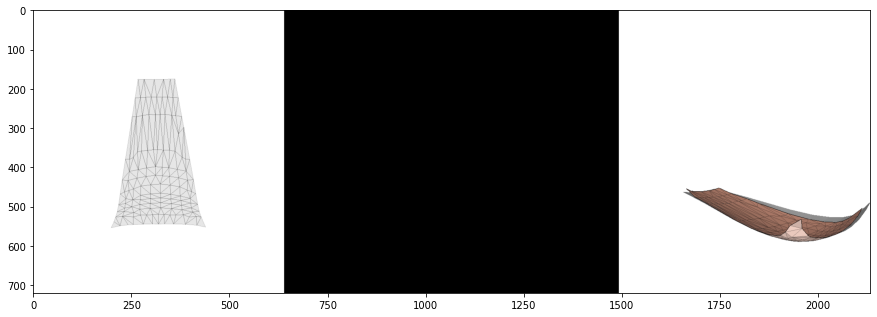

In [32]:
!xvfb-run -e /dev/stdout -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for bmp_file in sorted(list(pathlib.Path(vis_directory).glob('*.bmp'))):
    frames.append(plt.imread(bmp_file))
    #print(bmp_file)
    
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

In [ ]:
ani.save('apb.mp4')

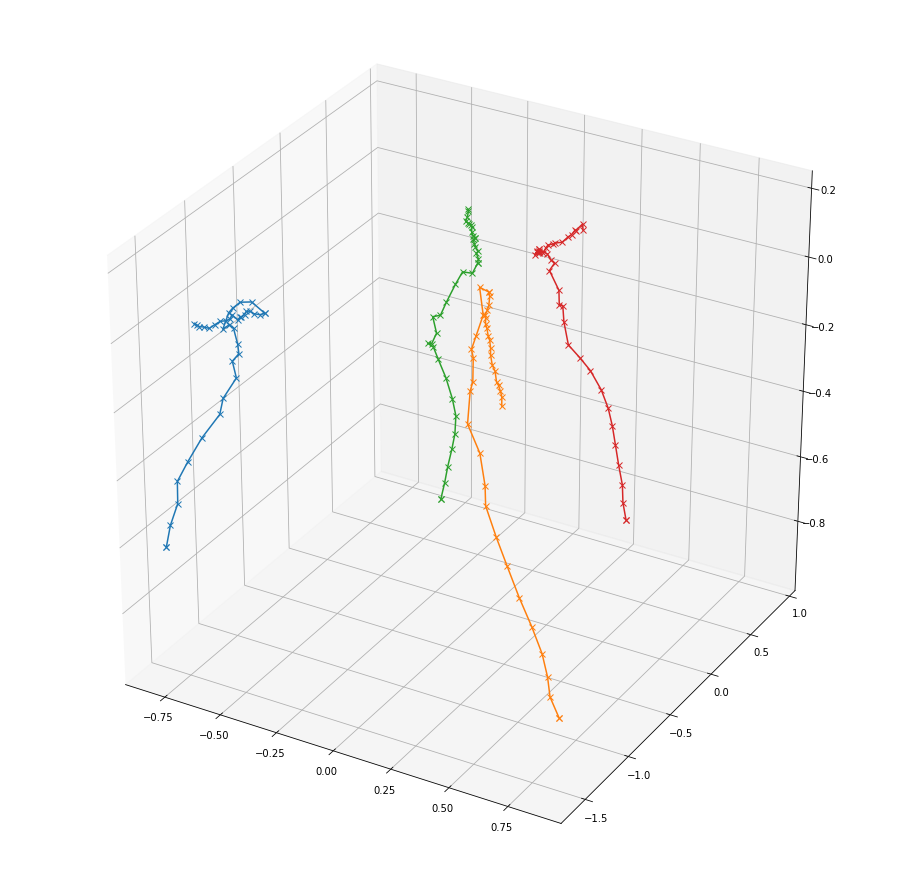

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(phase3_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')

plt.show()

In [ ]:
scene = trimesh.Scene(base_frame='world')

flat_mesh.visual.vertex_colors = [209, 158, 135, 255]
f_id = scene.add_geometry(flat_mesh)
c_id = scene.add_geometry(curved_mesh)

steps = 40

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

trajectories = np.array(trajectories) #this is positions, not vs
trajectories = np.diff(trajectories,axis=1) #vs
trajectories = trajectories.transpose(1,0,2)
trajectories = np.concatenate([trajectories,np.expand_dims(np.zeros_like(trajectories[0]),0)])

path = np.load('positions.npy')

for i in range(len(handles)):
    #original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(original_path)
    #optimized_path = trimesh.load_path(np.cumsum(phase3_v.detach().numpy()[:-2,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    #scene.add_geometry(optimized_path)
    scene.add_geometry(trimesh.load_path(path[:,i,:]))


scene.show()